In [29]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup

import requests
import matplotlib.pyplot as plt
import numpy
import pandas as pd  
from math import *
import time, datetime

now = str(time.time()).split('.')[0]
print(now)
print(str(datetime.datetime.now()).split('.')[0])
datetime.datetime.now().hour + datetime.datetime.now().minute
time.time() + 18000


1582323748
2020-02-21 17:22:28


1582341748.830288

In [30]:
bidsAreHigh = False
maPortfolio = 25000
maCash = 25000

url = "https://query1.finance.yahoo.com/v8/finance/chart/%5EGSPC?symbol=%5EGSPC&period1={}&period2={}&interval={}&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=ED2zlWJHcMa&corsDomain=finance.yahoo.com"
monthAgo = time.time() - 8419200
weekAgo = time.time() - 386329

r = requests.get(url.format(str(monthAgo).split('.')[0], now, '1d'))

# r = requests.get(url.format(str(monthAgo).split('.')[0], now, '30m'))
# r = requests.get("""https://query1.finance.yahoo.com/v8/finance/chart/%5EGSPC?symbol=%5EGSPC&period1=1574186393&period2=1576778393&interval=30m&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=ED2zlWJHcMa&corsDomain=finance.yahoo.com
# """)
yahoo = r.json()
print(yahoo)
time = yahoo["chart"]["result"][0]["timestamp"]
quote = yahoo["chart"]["result"][0]["indicators"]["quote"][0]



{'chart': {'result': [{'meta': {'currency': 'USD', 'symbol': '^GSPC', 'exchangeName': 'SNP', 'instrumentType': 'INDEX', 'firstTradeDate': -1325602800, 'regularMarketTime': 1582323392, 'gmtoffset': -18000, 'timezone': 'EST', 'exchangeTimezoneName': 'America/New_York', 'regularMarketPrice': 3337.75, 'chartPreviousClose': 3120.46, 'priceHint': 2, 'currentTradingPeriod': {'pre': {'timezone': 'EST', 'start': 1582275600, 'end': 1582295400, 'gmtoffset': -18000}, 'regular': {'timezone': 'EST', 'start': 1582295400, 'end': 1582318800, 'gmtoffset': -18000}, 'post': {'timezone': 'EST', 'start': 1582318800, 'end': 1582333200, 'gmtoffset': -18000}}, 'dataGranularity': '1d', 'range': '', 'validRanges': ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']}, 'timestamp': [1574087400, 1574173800, 1574260200, 1574346600, 1574433000, 1574692200, 1574778600, 1574865000, 1575037800, 1575297000, 1575383400, 1575469800, 1575556200, 1575642600, 1575901800, 1575988200, 1576074600, 1576161000

In [33]:
def ROC(df, n, price='Close'):
    """
    Rate of Change
    """
    M = df[price].diff(n - 1)
    N = df[price].shift(n - 1)
    result = pd.Series( round( M / N * 100, 2 ), name='ROC_' + str(n))
    return result

def MFI2(df, n):
    """
    Money Flow Index and Ratio
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < len(df) - 1:  # df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.iat[i + 1, df.columns.get_loc('Volume')])
        else:
            PosMF.append(0)
        i=i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    result = pd.Series(MFR.rolling(n).mean(), name='MFI_' + str(n))
    return result

def BBANDS(df, n, price='Close'):
    """
    Bollinger Bands
    """
    MA = pd.Series(df[price].rolling(n).mean())
    MSD = pd.Series(df[price].rolling(n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    b2 = (df[price] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    result = pd.DataFrame([B1, B2]).transpose()
    return result

def MACD(df, n_fast, n_slow, price='Close'):
    """
    MACD, MACD Signal and MACD difference
    """
    EMAfast = pd.Series(df[price].ewm(span=n_fast, min_periods=n_slow - 1).mean())
    EMAslow = pd.Series(df[price].ewm(span=n_slow, min_periods=n_slow - 1).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_%d_%d' % (n_fast, n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=8).mean(), name='MACDsign_%d_%d' % (n_fast, n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_%d_%d' % (n_fast, n_slow))
    result = pd.DataFrame([MACD, MACDsign, MACDdiff]).transpose()
    return result

def RSI(df, n):
    """
    Relative Strength Index
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= len(df) - 1:  # df.index[-1]
        UpMove = df.iat[i + 1, df.columns.get_loc('High')] - df.iat[i, df.columns.get_loc('High')]
        DoMove = df.iat[i, df.columns.get_loc('Low')] - df.iat[i + 1, df.columns.get_loc('Low')]
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n - 1).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n - 1).mean())
    result = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    return result

def STDDEV(df, n):
    """
    Standard Deviation
    """
    result = pd.Series(df['Close'].rolling(n).std(), name='STD_' + str(n))
    return result

# intialise data of lists. 
data = {'Open': quote['open'] , 
        'Low': quote['low'] , 
        'High': quote['high'], 
        'Close': quote['close'],
        'Volume': quote['volume']} 
  
# Create DataFrame 
df = pd.DataFrame(data) 
  
# Print the output. 
df 

,Open,Low,High,Close,Volume
0,3117.909912,3112.060059,3124.169922,3122.030029,3436690000
1,3127.449951,3113.469971,3127.639893,3120.179932,3590070000
2,3114.659912,3091.409912,3118.969971,3108.459961,4034890000
3,3108.489990,3094.550049,3110.110107,3103.540039,3720560000
4,3111.409912,3099.260010,3112.870117,3110.290039,3226780000
5,3117.439941,3117.439941,3133.830078,3133.639893,3511530000
6,3134.850098,3131.000000,3142.689941,3140.520020,4595590000
7,3145.489990,3143.409912,3154.260010,3153.629883,3033090000
8,3147.179932,3139.340088,3150.300049,3140.979980,1743020000
9,3143.850098,3110.780029,3144.310059,3113.870117,3268740000


    BollingerB_20  Bollinger%b_20
0             NaN             NaN
1             NaN             NaN
2             NaN             NaN
3             NaN             NaN
4             NaN             NaN
5             NaN             NaN
6             NaN             NaN
7             NaN             NaN
8             NaN             NaN
9             NaN             NaN
10            NaN             NaN
11            NaN             NaN
12            NaN             NaN
13            NaN             NaN
14            NaN             NaN
15            NaN             NaN
16            NaN             NaN
17            NaN             NaN
18            NaN             NaN
19       0.031591        1.092933
20       0.035641        1.003013
21       0.038480        0.924590
22       0.041448        0.965576
23       0.044789        1.000664
24       0.047571        0.951255
25       0.050589        0.891724
26       0.054790        0.927769
27       0.058421        0.877910
28       0.059

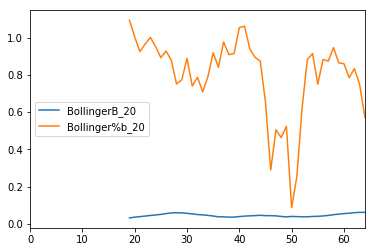

In [34]:
# mf = MFI(df, 14)
mfi = BBANDS(df, 20)
# print(mfi.values[-40:-20].mean())
print(mfi)
mfi.plot()

# descending = False
# thirtyMinMF_lastValue = mfi.values[-1:][0]
# if mfi.values[-20:].mean() > thirtyMinMF_lastValue:
#     descending = True
    
# print(descending)


# mf
# print(type(mfi[0]))
# mfi.values[-1:][0]
# print(df['Volume'].mean())
# print(df['Volume'].mean() / 100 * 150)
# highs = df[df['Volume'] > df['Volume'].mean() / 100 * 140]
# print('highs \n', highs)
# # if df['Close']
# df.iloc[[1,2], :]
# print(highs.values[0][3])
# highs.values[0][0]
# idx = df.index[df['Volume'] > df['Volume'].mean() / 100 * 130]
# print('len(idx)', idx[0])
# df.loc[idx]
# for i in range(len(idx)):
#     print(df['Close'][idx[i]-1])
#     if int(df['Close'][idx[i]-1]) > int(df['Close'][idx[i]]):
#         print ('bearish volume', df['Volume'][idx[i]])
#     else:
#         print ('bullish volume', df['Volume'][idx[i]])

-0.16


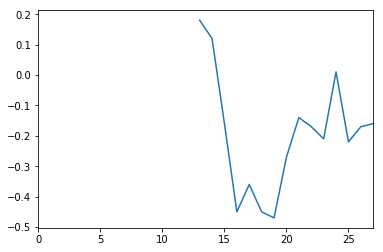

In [30]:
roc = ROC(df ,14)
print(roc.values[-1:][0])
roc.plot()
def RVI(df, n, high='High', low='Low'):
    """
    Relative Volatility Index
    """
    rvi_list = []
    h_upavg = .0
    h_dnavg = .0
    l_upavg = .0
    l_dnavg = .0
    i = 0
    while i < len(df[low]):
        if i + 1 < n or i < 9:
            h_rvi = float('NaN')
            l_rvi = float('NaN')
        else:
            start = i + 1 - n
            end = i + 1
            h = df[high][start:end]
            h_stdev = STDEV({'h': h}, 9, 'h')[-1]
            if df[high][i] > df[high][i - 1]:
                h_up = h_stdev
                h_dn = 0
            else:
                h_up = 0
                h_dn = h_stdev
            h_upavg = (h_upavg * (n - 1) + h_up) / n
            h_dnavg = (h_dnavg * (n - 1) + h_dn) / n
            h_rvi = 100 * h_upavg / (h_upavg + h_dnavg)
            l = df[low][start:end]
            l_stdev = STDEV({'l': l}, 9, 'l')[-1]
            if df[low][i] > df[low][i - 1]:
                l_up = l_stdev
                l_dn = 0
            else:
                l_up = 0
                l_dn = l_stdev
            l_upavg = (l_upavg * (n - 1) + l_up) / n
            l_dnavg = (l_dnavg * (n - 1) + l_dn) / n
            l_rvi = 100 * l_upavg / (l_upavg + l_dnavg)
        rvi = (h_rvi + l_rvi) / 2
        rvi_list.append(rvi)
        i += 1
    return rvi_list


def STDEV(df, n, price='Close', xbar=None):
    """
    Sample standard deviation of data
    """
    stdev_list = []
    i = 0
    if n == len(df[price]):
        start = None
        while i < len(df[price]):
            if df[price][i] != df[price][i]:
                stdev = float('NaN')
            else:
                if start is None:
                    start = i
                end = i + 1
                if len(df[price][start:end]) < 2:
                    stdev = float('NaN')
                else:
                    stdev = stdev(df[price][start:end], xbar)
            stdev_list.append(stdev)
            i += 1
    else:
        while i < len(df[price]):
            if i + 1 < n:
                stdev = float('NaN')
            else:
                start = i + 1 - n
                end = i + 1
                if len(df[price][start:end]) < 2:
                    stdev = float('NaN')
                else:
                    stdev = stdev(df[price][start:end], xbar)
            stdev_list.append(stdev)
            i += 1
    return stdev_list

# std = RVI(df, 14)
# std.plot()




In [2]:
def buy(stockPrice, n):
#     getAmount
#     subtract
#     keep the amount as a sum of stock value and the remaining cash
    stocksValue = stockPrice * n
    maCash = maCash - stocksValue
    
book = None
bookSoup = None
browser = webdriver.Chrome('C:\chromedriver')
bookRaw = None

def startBrowser():
    global book
    global bookSoup
    global browser
    global bookRaw
    browser.get('http://markets.cboe.com/us/equities/market_statistics/book_viewer/')
    time.sleep(2)
    EDGX = browser.find_element_by_xpath('//span[text()="EDGX Equities"]')
    actions = ActionChains(browser)
    actions.pause(1)
    print(EDGX)
    actions.click(EDGX)
    actions.pause(1)
    actions.perform()
    bookRaw = browser.find_element_by_xpath('//*[@id="bookViewer0"]/div[1]/table[2]/tbody')
    price = browser.find_element_by_class_name('book-viewer__trades-price').text
#     shares = 
    book = bookRaw.get_attribute('innerHTML')
    bookSoup = BeautifulSoup(book, 'lxml').html.body
    i = 0
#     for row in bookSoup:
#         i+=1
#         print('row number %s printing' % i)
#         for subrow in row:
#             print(subrow)
    print(price)
    print('book ===============>', book)
    print('bookSoup ===============>', bookSoup)
    
    
startBrowser()

<selenium.webdriver.remote.webelement.WebElement (session="8c38baa765c95c672cdaf1335c15467a", element="29c93eb0-81f6-4394-8ee3-5c77c19fdf12")>
322.42
book ===============> 
              <tr class="book-viewer-data-row">
                  <td class="book-viewer__ask__th t5" rowspan="5" style="display: table-cell;"><i class="sprite book-viewer__sprite book-viewer__sprite--ask"></i><span class="hide">Asks</span></td>
                  <td class="book-viewer__ask book-viewer__ask-shares" id="ext-gen1052" style="display: table-cell;">3,772</td>
                  <td class="book-viewer__ask book-viewer__ask-quotes" id="ext-gen1054" style="display: none;">&nbsp;</td>
                  <td class="book-viewer__ask book-viewer__ask-price book-viewer-price" id="ext-gen1053" style="display: table-cell;">322.54</td>
                  <td class="book-viewer__trades-time" id="ext-gen1084" style="display: table-cell;">18:34:37</td>
                  <td class="book-viewer__trades-price" id="ext-gen10

In [ ]:
i = 0
attachment = []
last10Trades = browser.find_elements_by_class_name("book-viewer__trades-price")
topBidsPrice = browser.find_elements_by_class_name("book-viewer__bid-price")
topBidShares = browser.find_elements_by_class_name("book-viewer__bid-shares")
topAskPrice = browser.find_elements_by_class_name("book-viewer__ask-price")
topAskShares = browser.find_elements_by_class_name("book-viewer__ask-shares")

print(last10Trades)
print(topBidsPrice)

for i in topBids:
    if i.text > 1600:
        print(i, i.text)
# for row in bookSoup:
#     i+=1
#     print('rw number %s printing' % i)
#     r = bookRaw.find_all("td", { "class": "book-viewer__trades-price"})
#     attachment.append(r)
    
#     for subrow in row:
# #        tag.has_attr('class')
#         s = subrow.string
#         print(type(s))
#         except NavigableString: 
#             pass
print(attachment)

In [ ]:
from selenium.webdriver.common.keys import Keys
def changeStock(stock):
#     global browser
    inputt = browser.find_element_by_xpath('//*[@id="symbol0"]')
    actions = ActionChains(browser)
    actions.move_to_element(inputt)
    actions.double_click(inputt)
    actions.send_keys(Keys.BACKSPACE)
#     actions.pause(1)
    actions.send_keys(stock)
#     actions.pause(1)
    actions.send_keys(Keys.ENTER)
    actions.perform()

changeStock('EDIT')
        

In [ ]:
tvixdata = pd.read_csv("C:/Users/Ldeezy/Desktop/git_/TRADER/tvix_December26_19-tradingHours.csv") 

# tvixdata[::-1]
tvixdata.reindex(index=tvixdata.index[::-1])
tvixdata.

In [ ]:
prices = tvixdata['Last Price']
prices

In [ ]:
prices.plot()

In [ ]:
import threading

def shit():
    print('yo')

StartTime=time.time()

def action() :
    print('action ! -> time : {:.1f}s'.format(time.time()-StartTime))


class setInterval :
    def __init__(self,interval,action) :
        self.interval=interval
        self.action=action
        self.stopEvent=threading.Event()
        thread=threading.Thread(target=self.__setInterval)
        thread.start()

    def __setInterval(self) :
        nextTime=time.time()+self.interval
        while not self.stopEvent.wait(nextTime-time.time()) :
            nextTime+=self.interval
            self.action()

    def cancel(self) :
        self.stopEvent.set()

# start action every 0.6s
inter=setInterval(0.6,action)
print('just after setInterval -> time : {:.1f}s'.format(time.time()-StartTime))

# will stop interval in 5s
t=threading.Timer(5,inter.cancel)
t.start()

In [33]:
time.time()
print('time.time()=>', time.time())
today = datetime.datetime.now()
print('datetime.datetime.now()=>', today)
today_morning = today.strftime('%Y%m%d') + "000000"
today_morning
midnight = datetime.datetime.combine(datetime.datetime.today(), datetime.time.min)
time.time()
midnight


time.time()=> 1577575976.6751726
datetime.datetime.now()=> 2019-12-28 18:32:56.676170


datetime.datetime(2019, 12, 28, 0, 0)

In [18]:
result = time.localtime(1545925769)
print("result:", result)
print("\nyear:", result.tm_year)
print("tm_hour:", result.tm_hour)

result: time.struct_time(tm_year=2018, tm_mon=12, tm_mday=27, tm_hour=10, tm_min=49, tm_sec=29, tm_wday=3, tm_yday=361, tm_isdst=0)

year: 2018
tm_hour: 10


In [19]:
t = (2018, 12, 28, 8, 44, 4, 4, 362, 0)
local_time = time.mktime(t)
print("Local time:", local_time)

Local time: 1546004644.0


In [40]:
datetime.datetime.today().time()
str(datetime.datetime.today().date())

'2019-12-28'

In [3]:
>>> import time
>>> from datetime import datetime, date
s = str(datetime.today().date())
startOfDay = str( time.mktime(datetime.strptime(s, "%Y-%m-%d").timetuple())).split('.')[0]
fiveHourPending = 0
today = [ datetime.now().year, datetime.now().month, datetime.now().day ]
print('day of week', type(date(*today).weekday()))
timestamp_now = time.time()
print(datetime.now().hour)
if datetime.now().hour < 16:
    deltaTillClose = datetime(*today, 16,0) - datetime.now()
    print(deltaTillClose)
    print(deltaTillClose.seconds/60)
    print('setting five hour timestamp. {} minutes till close.'.format(deltaTillClose.seconds/60))
    if deltaTillClose.seconds < 18000 and deltaTillClose.seconds > 0:
        if date(*today).weekday() == 4:
            fiveHourPending = timestamp_now + 234000
            print('five hour deadline set for Monday at ', datetime.fromtimestamp(fiveHourPending))
        else:
            fiveHourPending = timestamp_now + 81000
            print('five hour deadline set for tomorrow at ', datetime.fromtimestamp(fiveHourPending))
else:
    deltaTill8pm = (datetime(*today, 20,0) - datetime.now()).seconds
    print(deltaTill8pm)
    fiveHourPending = timestamp_now + 66600 + deltaTill8pm
    
    print('five hour deadline set for tomorrow at ', datetime.fromtimestamp(fiveHourPending))
    if date(*today).weekday() == 4:
        fiveHourPending = timestamp_now + 239400 + deltaTill8pm
        print('five hour deadline set for Monday at ', datetime.fromtimestamp(fiveHourPending))
# else:
#         fiveHourPending = timestamp_now + 18000
#         print('five hour deadline set for today at ', datetime.fromtimestamp(fiveHourPending))
fiveHourPending
today = [ datetime.now().year, datetime.now().month, datetime.now().day ]
datetime(*today, 9,28) > datetime.now()

day of week <class 'int'>
12
3:33:01.577819
213.01666666666668
setting five hour timestamp. 213.01666666666668 minutes till close.
five hour deadline set for tomorrow at  2020-02-19 10:56:58.422181


False

In [54]:
startOfDay

'1577595600'

In [1]:
1581690599 + 18000

1581708599

40.0